In [40]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import copy
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model


## Carregando os dados já com os códigos de países inclusos
(utilizamos o caderno `coords_to_country.ipynb` para gerar os códigos)


In [2]:
data = pd.read_pickle("../datasets/20kSongs_with_countries.pickle")

In [3]:
data.head(5)

,analysis_sample_rate,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_mbtags,...,tatums_confidence,tatums_start,tempo,time_signature,time_signature_confidence,title,track_7digitalid,track_id,year,artist_country_code
0,22050,27724,0.559823,0.391484,ARE93YV1187B9937CC,7.36529,Cameroon,12.34344,bc30924c-1900-41c3-9a97-41a93433836f,"[world, folk]",...,"[0.455, 0.435, 0.4, 0.375, 0.362, 0.354, 0.35,...","[0.20916, 0.42014, 0.63112, 0.84316, 1.05454, ...",139.092,4,0.000,Journey (Album Version),412977,TRCCCRP128F147BEFA,1995,cm
1,22050,79,0.783031,0.478411,AR9FKRD1187B9B73D4,51.55503,"Hampstead, London, England",-0.17348,14ed9dea-1bb0-4743-ba32-39674a71da89,[classic pop and rock],...,"[0.613, 0.608, 0.57, 0.539, 0.516, 0.493, 0.47...","[0.66188, 1.06217, 1.45659, 1.84906, 2.23956, ...",76.595,4,0.595,Great Expectations,319733,TRCCZOW128F146A22D,1999,gb
2,22050,368022,0.635055,0.394375,AR0BO8O1187B992CC1,53.64746,"Huddersfield, UK",-1.79723,5540499f-8ab5-404f-a781-e959b1dc2778,[thrash metal],...,"[0.263, 0.271, 0.247, 0.218, 0.194, 0.172, 0.1...","[0.02909, 0.17137, 0.3166, 0.46478, 0.60485, 0...",203.897,4,0.000,Now Demolition,7666264,TRCCZQN12903CF5F22,2009,gb
3,22050,11189,0.721520,0.503304,ARD8ODS1187FB4ADFA,54.97791,Newcastle - Engeland,-1.61237,92e634a7-6023-4be8-be15-ebba822f5b34,"[british, uk, britannique, rock and indie, ind...",...,"[1.0, 1.0, 0.92, 0.837, 0.787, 0.721, 0.672, 0...","[0.34004, 0.71788, 1.09756, 1.47535, 1.85315, ...",78.485,4,0.165,I Want You To Stay,2018189,TRCCZZR128F4239D6F,2005,gb
4,22050,167141,0.718250,0.478790,ARNCTJ91187B98D813,49.89942,"Winnipeg, Manitoba, Canada",-97.14074,56abaa47-0101-463b-b37e-e961136fec39,"[breakcore, gabber, idm, drill n bass, electro...",...,"[0.712, 0.66, 0.626, 0.586, 0.555, 0.537, 0.50...","[0.12177, 0.30471, 0.48857, 0.66967, 0.85537, ...",109.294,5,0.976,Banana Seat Girl,2665622,TRCCZMW128F4240542,2002,ca


In [4]:
# Transformando song_hotttnesss de valores contínuos para valores discretos
threshold = 0.6
data['song_hotttnesss'] = (data['song_hotttnesss'] > threshold).astype(int)

In [5]:
# Fazendo label encoding para do artist id
le = preprocessing.LabelEncoder()
data['artist_id'] = le.fit_transform(data['artist_id'].astype('str'))

In [6]:
# Fazendo label encoding (one hot) dos códigos de país

# Pegar one hot encoding da coluna
one_hot = pd.get_dummies(data['artist_country_code'])
# Drop da coluna, uma vez que já está codificada
data = data.drop('artist_country_code',axis = 1)
# Join do dataframe codificado com o original
data = data.join(one_hot)

In [7]:
# Distribuição gráfica de músicas que são "hot"
def freq(col):
   g = sns.kdeplot(data[col][(data["song_hotttnesss"] == 1)], color="Blue", shade = True)
   g.set_xlabel(col)
   g.set_ylabel("Frequency")
   g = g.legend(["1"])
   plt.show()

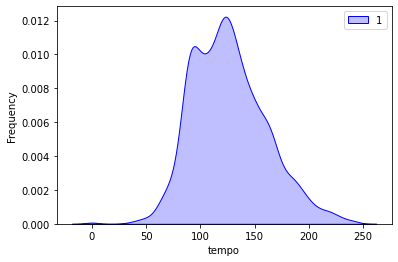

In [8]:
freq("tempo")

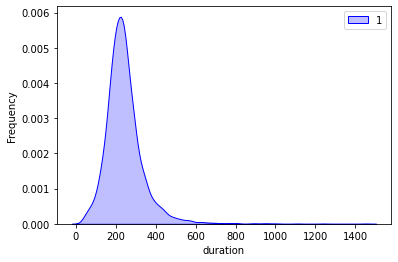

In [9]:
freq("duration")

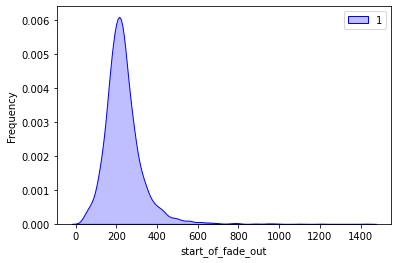

In [10]:
freq("start_of_fade_out")

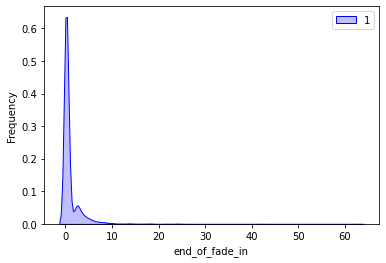

In [11]:
freq("end_of_fade_in")

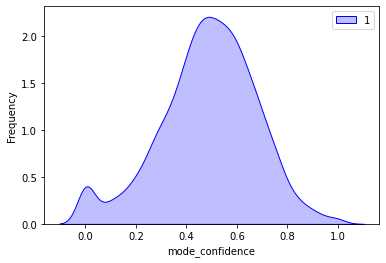

In [12]:
freq("mode_confidence")

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19981 entries, 0 to 19999
Columns: 110 entries, analysis_sample_rate to za
dtypes: float64(14), int32(9), int64(2), object(29), uint8(56)
memory usage: 9.3+ MB


In [15]:
# Se quisermos delimitar o tamanho do DF para rodar mais rápido
# data = data[:10000]
# data.info()

In [16]:
interesting_cols = [
    "artist_familiarity",
    "artist_hotttnesss",
    "artist_id",
    "artist_country_code",
    "year",
    "time_signature",
    "duration",
    "key",
    "tempo",
    "mode",
    "mode_confidence",
    "time_signature_confidence",
    "end_of_fade_in",
    "loudness",
    "start_of_fade_out",
    "key_confidence",
    "song_hotttnesss",
]

drop_list = [col for col in data.columns if col not in interesting_cols]
drop_list


['analysis_sample_rate',
 'artist_7digitalid',
 'artist_latitude',
 'artist_location',
 'artist_longitude',
 'artist_mbid',
 'artist_mbtags',
 'artist_mbtags_count',
 'artist_name',
 'artist_playmeid',
 'artist_terms',
 'artist_terms_freq',
 'artist_terms_weight',
 'audio_md5',
 'bars_confidence',
 'bars_start',
 'beats_confidence',
 'beats_start',
 'danceability',
 'energy',
 'release',
 'release_7digitalid',
 'sections_confidence',
 'sections_start',
 'segments_confidence',
 'segments_loudness_max',
 'segments_loudness_max_time',
 'segments_loudness_start',
 'segments_pitches',
 'segments_start',
 'segments_timbre',
 'similar_artists',
 'song_id',
 'tatums_confidence',
 'tatums_start',
 'title',
 'track_7digitalid',
 'track_id',
 'ar',
 'at',
 'au',
 'bb',
 'be',
 'br',
 'ca',
 'ch',
 'cl',
 'cm',
 'cn',
 'co',
 'cu',
 'cz',
 'de',
 'dk',
 'do',
 'dz',
 'eg',
 'es',
 'fi',
 'fr',
 'gb',
 'gr',
 'gy',
 'id',
 'ie',
 'il',
 'im',
 'in',
 'ir',
 'is',
 'it',
 'jm',
 'jp',
 'lb',
 'lv',


In [17]:
train = data.drop(drop_list, axis=1)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19981 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artist_familiarity         19981 non-null  float64
 1   artist_hotttnesss          19981 non-null  float64
 2   artist_id                  19981 non-null  int64  
 3   duration                   19981 non-null  float64
 4   end_of_fade_in             19981 non-null  float64
 5   key                        19981 non-null  int32  
 6   key_confidence             19981 non-null  float64
 7   loudness                   19981 non-null  float64
 8   mode                       19981 non-null  int32  
 9   mode_confidence            19981 non-null  float64
 10  song_hotttnesss            19981 non-null  int64  
 11  start_of_fade_out          19981 non-null  float64
 12  tempo                      19981 non-null  float64
 13  time_signature             19981 non-null  int

In [19]:
Y = copy.deepcopy(train.song_hotttnesss)
Y.shape

(19981,)

In [20]:
train["artist_familiarity"] = train["artist_familiarity"].fillna(train["artist_familiarity"].median())

In [21]:
train1 = train.drop("song_hotttnesss", axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train1, Y, test_size=0.33, random_state=7)

In [24]:
model = XGBClassifier()
model.fit(X_train, y_train)

# Fazer previsões para os dados de teste
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {round(accuracy * 100, 2,)}%")


Accuracy: 79.63%


In [26]:
# Função para avaliar o modelo com Cross validation
from sklearn.model_selection import cross_val_score
def testingModel(model, X_train, Y_train):
    scores = cross_val_score(model, X_train, Y_train, cv=10)
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    return scores.mean()

In [27]:
# 79%
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf.fit(train1, Y)
acc_random_forest = testingModel(rf, train1, Y)
print(f"Accuracy: {round(acc_random_forest*100,2,)}%")


Scores: [0.78989495 0.78778779 0.7962963  0.81181181 0.8048048  0.77927928
 0.7962963  0.79429429 0.78078078 0.80630631]
Mean: 0.7947552605131394
Standard Deviation: 0.010184637509383828
Accuracy: 79.48%


In [29]:
# 79%
xgb1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    nthread=4,
    scale_pos_weight=1,
    seed=27,
)
xgb1.fit(train1, Y)
acc_xgb = testingModel(xgb1, train1, Y)

print(f"Accuracy: {round(acc_xgb * 100,2,)}%")

Scores: [0.79289645 0.79279279 0.79079079 0.80630631 0.80980981 0.78178178
 0.7962963  0.77977978 0.78628629 0.8043043 ]
Mean: 0.794104459637226
Standard Deviation: 0.009678392971735297
Accuracy: 79.41%


In [32]:
# 72%
logreg = LogisticRegression()

logreg.fit(train1, Y)

acc_log = testingModel(logreg, train1, Y)

print(f"Accuracy: {round(acc_log*100,2,)}%")

/home/ylaguardia/code/puc-ai-ml/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ylaguardia/code/puc-ai-ml/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Scores: [0.72486243 0.72672673 0.72522523 0.72672673 0.72672673 0.72572573
 0.72622623 0.72622623 0.72672673 0.72572573]
Mean: 0.7260898467251644
Standard Deviation: 0.0006464480379660665
Accuracy: 72.61%


/home/ylaguardia/code/puc-ai-ml/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
# 67%
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(train1, Y)

acc_knn = testingModel(knn, train1, Y)

print(f"Accuracy: {round(acc_knn*100,2,)}%")

Scores: [0.66683342 0.67717718 0.65865866 0.66116116 0.67317317 0.68618619
 0.66716717 0.66366366 0.67117117 0.68418418]
Mean: 0.6709375959250897
Standard Deviation: 0.008844760202389227
Accuracy: 67.09%


In [35]:
# 63%
linear_svc = LinearSVC()
linear_svc.fit(train1, Y)

acc_linear_svc = testingModel(linear_svc, train1, Y)

print(f"Accuracy: {round(acc_linear_svc*100,2,)}%")

/home/ylaguardia/code/puc-ai-ml/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ylaguardia/code/puc-ai-ml/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ylaguardia/code/puc-ai-ml/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ylaguardia/code/puc-ai-ml/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ylaguardia/code/puc-ai-ml/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ylaguardia/code/puc

Scores: [0.72636318 0.37437437 0.62312312 0.66966967 0.72622623 0.72672673
 0.72622623 0.27427427 0.72622623 0.72622623]
Mean: 0.6299436254663867
Standard Deviation: 0.15785628389472425
Accuracy: 62.99%


/home/ylaguardia/code/puc-ai-ml/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [38]:
# 74%
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train1, Y)

acc_decision_tree = testingModel(decision_tree, train1, Y)

print(f"Accuracy: {round(acc_decision_tree*100,2,)}%")

Scores: [0.74187094 0.72722723 0.73973974 0.73623624 0.74724725 0.74124124
 0.76476476 0.75175175 0.73323323 0.73223223]
Mean: 0.7415544609141407
Standard Deviation: 0.0103358703247782
Accuracy: 74.16%


In [39]:
# 64%
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
acc_sgd = testingModel(sgd, train1, Y)  

print(f"Accuracy: {round(acc_sgd*100,2,)}%")

Scores: [0.71935968 0.72672673 0.27327327 0.72622623 0.72672673 0.72672673
 0.3038038  0.72622623 0.72622623 0.72172172]
Mean: 0.6377017337497578
Standard Deviation: 0.17473105459368798
Accuracy: 63.77%


In [41]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'XGB', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_xgb, 
             acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(7)

,Model
Score,
0.794755,Random Forest
0.794104,XGB
0.741554,Decision Tree
0.726090,Logistic Regression
0.670938,KNN
0.629944,Support Vector Machines
